In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.ar_model import ar_select_order
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

sns.set()
plt.rcParams['figure.figsize'] = (20,6)

In [2]:
wiki = pd.read_csv('siteviews_2015_2021.csv', index_col=0, parse_dates=True)

In [3]:
wiki = wiki.rename(columns={'en.wikipedia.org': 'siteviews'})

In [4]:
wiki

,siteviews
Date,
2015-07-01,243497551
2015-07-02,241866978
2015-07-03,226919786
2015-07-04,226583272
2015-07-05,240912348
...,...
2021-02-19,256601130
2021-02-20,257535699
2021-02-21,273132746


In [5]:
wiki.shape

(2065, 1)

In [6]:
def plot_wiki(df, title='Daily Siteviews over Time'):
    '''    
    Parameters
    ----------
    df : pd.DataFrame, the data to plot.
    title : str, the title of the plot.
    ylim : bool, whether to fix the minimum value of y; defalut is True.
    
    Returns
    -------
    Plots the data
    '''
    df.plot()
    plt.title(title)
    plt.ylabel('# of Siteviews in 100 M')
    plt.margins(x=0)
    plt.show()

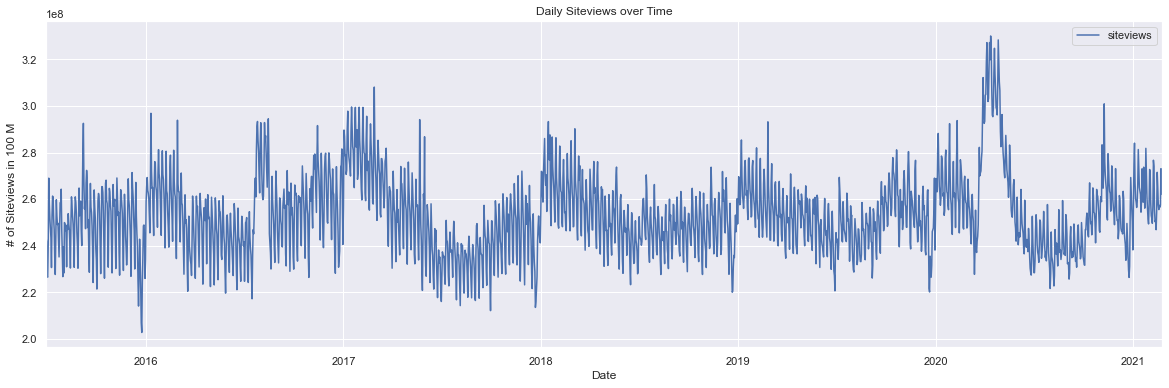

In [7]:
plot_wiki(wiki);

In [8]:
wiki.index

#set freq of data
#wiki.index.freq = 'd'

DatetimeIndex(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04',
               '2015-07-05', '2015-07-06', '2015-07-07', '2015-07-08',
               '2015-07-09', '2015-07-10',
               ...
               '2021-02-14', '2021-02-15', '2021-02-16', '2021-02-17',
               '2021-02-18', '2021-02-19', '2021-02-20', '2021-02-21',
               '2021-02-22', '2021-02-23'],
              dtype='datetime64[ns]', name='Date', length=2065, freq=None)

#### TRAIN-TEST-SPLIT

In [9]:
wiki_train, wiki_test = train_test_split(wiki, test_size=0.3, shuffle=False)

In [10]:
wiki_train.shape, wiki_test.shape

((1445, 1), (620, 1))

#### Exploring the data

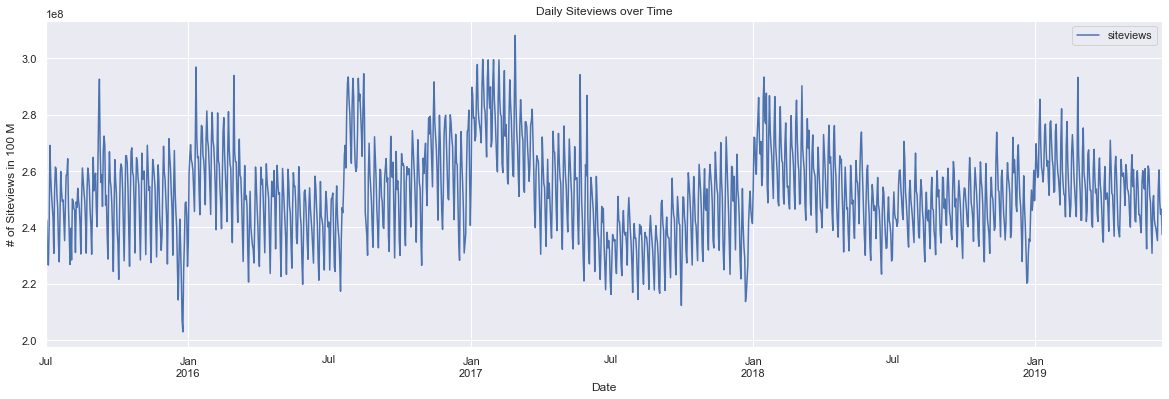

In [11]:
plot_wiki(wiki_train)

In [12]:
wiki_train.isna().sum() # or.any()

siteviews    0
dtype: int64

In [13]:
"%.2f" % wiki_train.mean() # average of daily siteviews

'252133363.49'

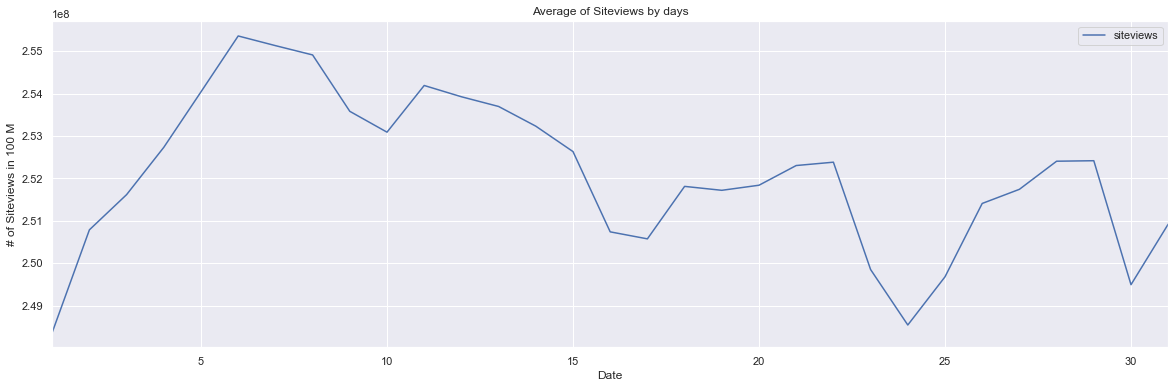

In [14]:
#average of siteviews by day
wiki_train.groupby(wiki_train.index.day).mean().plot(title='Average of Siteviews by days')
plt.ylabel('# of Siteviews in 100 M')
plt.margins(x=0)
plt.show()

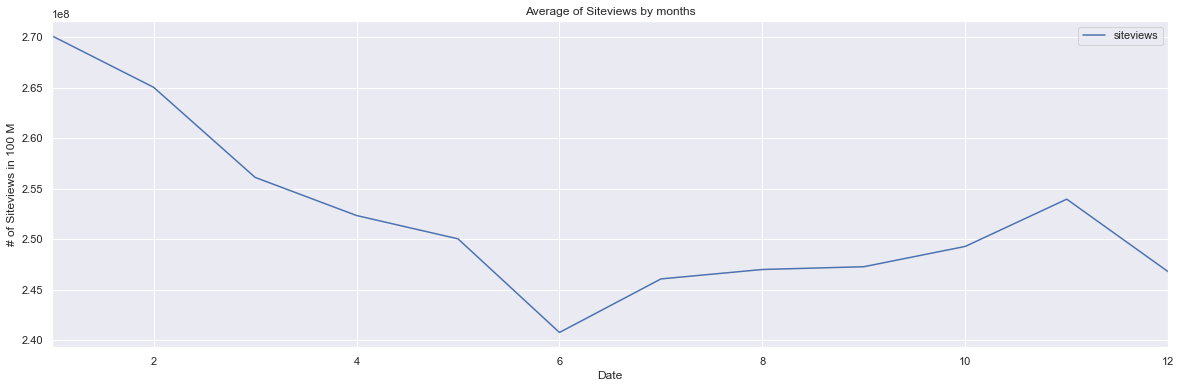

In [15]:
#average of siteviews by month (seasonality)
wiki_train.groupby(wiki_train.index.month).mean().plot(title='Average of Siteviews by months')
plt.ylabel('# of Siteviews in 100 M')
plt.margins(x=0)
plt.show()

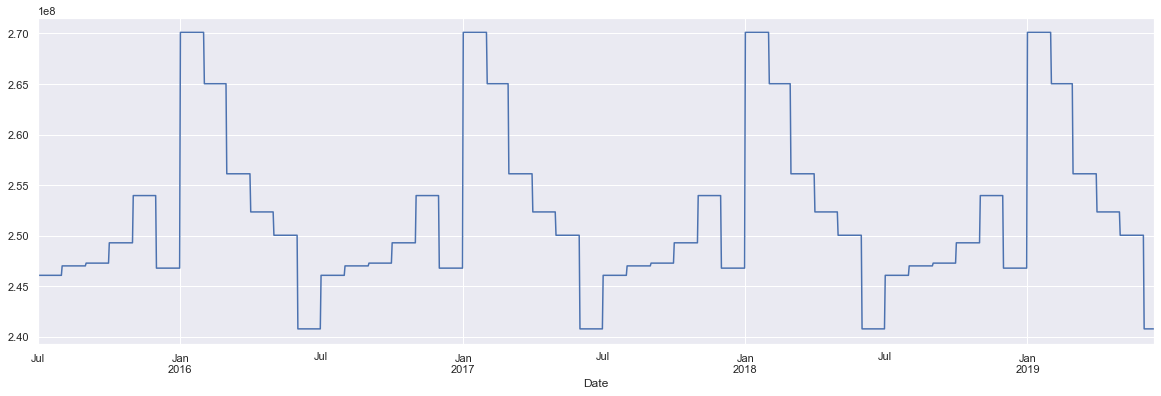

In [16]:
#extract seasonality
wiki_train.groupby(wiki_train.index.month)['siteviews'].transform('mean').plot();

#### Extract the Timestep and the Seasonal Dummies

In [17]:
# Create a timestep variable (trend)
wiki_train['timestep'] = list(range(len(wiki_train)))

<ipython-input-17-e0b618756766>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wiki_train['timestep'] = list(range(len(wiki_train)))


In [18]:
wiki_train.head()

,siteviews,timestep
Date,,
2015-07-01,243497551,0
2015-07-02,241866978,1
2015-07-03,226919786,2
2015-07-04,226583272,3
2015-07-05,240912348,4


In [19]:
# Create the seasonal dummies for seasonality
seasonal_dummies = pd.get_dummies(wiki_train.index.month,
                                  prefix='month',
                                  drop_first=True).set_index(wiki_train.index)

wiki_train = wiki_train.join(seasonal_dummies)

In [20]:
wiki_train.head()

,siteviews,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
Date,,,,,,,,,,,,,
2015-07-01,243497551,0,0,0,0,0,0,1,0,0,0,0,0
2015-07-02,241866978,1,0,0,0,0,0,1,0,0,0,0,0
2015-07-03,226919786,2,0,0,0,0,0,1,0,0,0,0,0
2015-07-04,226583272,3,0,0,0,0,0,1,0,0,0,0,0
2015-07-05,240912348,4,0,0,0,0,0,1,0,0,0,0,0


#### Trend_Seasonal model

In [21]:
#define X and y
X = wiki_train.drop(columns = ['siteviews']) #matrix
y = wiki_train['siteviews'] #vector

In [22]:
# Create and fit the model
m_ts = LinearRegression()
m_ts.fit(X, y)

LinearRegression()

In [23]:
# Create a new column with the predictions of the trend_seasonal model
wiki_train['trend_seasonal'] = m_ts.predict(X)
wiki_train.head(3)

,siteviews,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal
Date,,,,,,,,,,,,,,
2015-07-01,243497551,0,0,0,0,0,0,1,0,0,0,0,0,2.472958e+08
2015-07-02,241866978,1,0,0,0,0,0,1,0,0,0,0,0,2.472936e+08
2015-07-03,226919786,2,0,0,0,0,0,1,0,0,0,0,0,2.472915e+08


#### Plot the original data and preliminary model

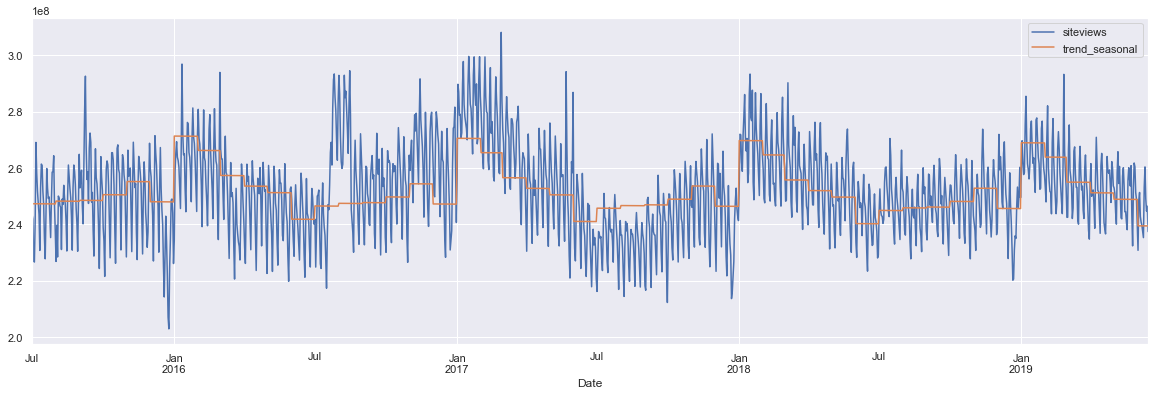

In [24]:
wiki_train[['siteviews', 'trend_seasonal']].plot();

#### Extract the remainder

In [25]:
# extract the part of the model that the trend_seasonal is not able to explain
wiki_train['remainder'] = wiki_train['siteviews'] - wiki_train['trend_seasonal']

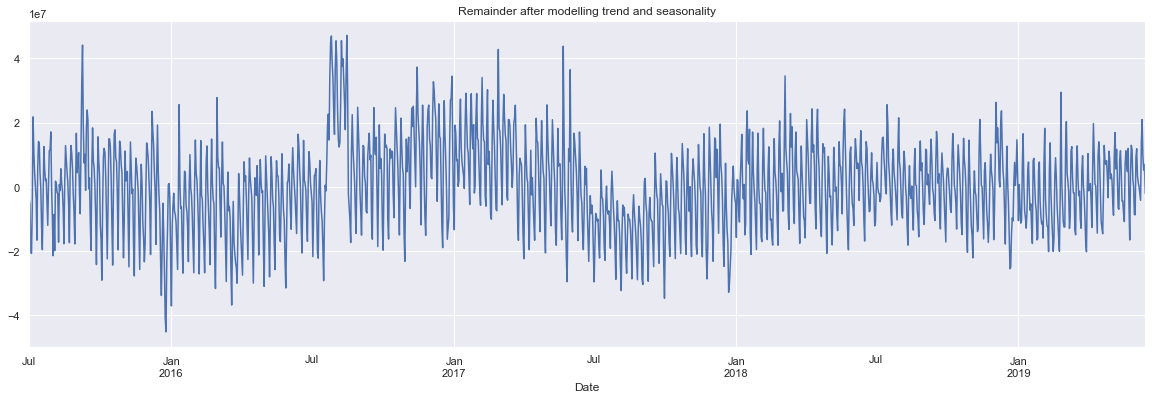

In [26]:
wiki_train['remainder'].plot(title='Remainder after modelling trend and seasonality');

####  Inspect the remainder to decide how many lags to include

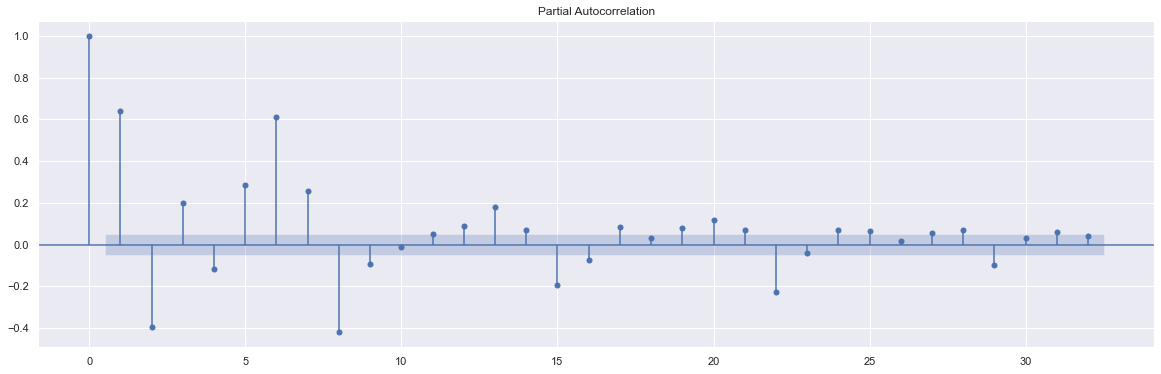

In [27]:
plot_pacf(wiki_train['remainder']);

In [28]:
# Box-Jenkins-Methodology
selected_order = ar_select_order(wiki_train['remainder'], maxlag = 12)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [29]:
# How many lags does ar_select_order
selected_order.ar_lags

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [30]:
selected_order.bic

{(1, 2, 3, 4, 5, 6, 7, 8, 9): 31.334222762473875,
 (1, 2, 3, 4, 5, 6, 7, 8): 31.33751510686254,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10): 31.33905227627548,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12): 31.339684608973787,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11): 31.34142115060167,
 (1, 2, 3, 4, 5, 6, 7): 31.52863877980668,
 (1, 2, 3, 4, 5, 6): 31.59305012342638,
 (1, 2, 3, 4, 5): 32.049068131783635,
 (1, 2, 3, 4): 32.130034559689534,
 (1, 2, 3): 32.13874552185223,
 (1, 2): 32.17528000078773,
 (1,): 32.33930048935494,
 0: 32.859808996511056}

In [31]:
wiki_train['lag1'] = wiki_train['remainder'].shift(1)
wiki_train['lag2'] = wiki_train['remainder'].shift(2)
wiki_train['lag3'] = wiki_train['remainder'].shift(3)
wiki_train['lag4'] = wiki_train['remainder'].shift(4)
wiki_train['lag5'] = wiki_train['remainder'].shift(5)
wiki_train['lag6'] = wiki_train['remainder'].shift(6)
wiki_train['lag7'] = wiki_train['remainder'].shift(7)
wiki_train['lag8'] = wiki_train['remainder'].shift(8)
wiki_train['lag9'] = wiki_train['remainder'].shift(9)
wiki_train.dropna(inplace=True)
wiki_train.head(3)

,siteviews,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,remainder,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-10,243476493,9,0,0,0,0,0,1,0,0,...,-3.799818e+06,2.419864e+05,4.375008e+06,1.087181e+07,2.178483e+07,-6.374784e+06,-2.070602e+07,-2.037167e+07,-5.426646e+06,-3.798237e+06
2015-07-11,230702775,10,0,0,0,0,0,1,0,0,...,-1.657137e+07,-3.799818e+06,2.419864e+05,4.375008e+06,1.087181e+07,2.178483e+07,-6.374784e+06,-2.070602e+07,-2.037167e+07,-5.426646e+06
2015-07-12,252692016,11,0,0,0,0,0,1,0,0,...,5.420033e+06,-1.657137e+07,-3.799818e+06,2.419864e+05,4.375008e+06,1.087181e+07,2.178483e+07,-6.374784e+06,-2.070602e+07,-2.037167e+07


In [32]:
wiki_train.columns

Index(['siteviews', 'timestep', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'trend_seasonal', 'remainder', 'lag1', 'lag2', 'lag3',
       'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9'],
      dtype='object')

#### Run the full model

In [33]:
# Assign X and y
X_full = wiki_train.drop(columns=['siteviews', 'trend_seasonal', 'remainder'])
y_full = wiki_train['siteviews']

In [34]:
X_full.head()

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,...,month_12,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-10,9,0,0,0,0,0,1,0,0,0,...,0,2.419864e+05,4.375008e+06,1.087181e+07,2.178483e+07,-6.374784e+06,-2.070602e+07,-2.037167e+07,-5.426646e+06,-3.798237e+06
2015-07-11,10,0,0,0,0,0,1,0,0,0,...,0,-3.799818e+06,2.419864e+05,4.375008e+06,1.087181e+07,2.178483e+07,-6.374784e+06,-2.070602e+07,-2.037167e+07,-5.426646e+06
2015-07-12,11,0,0,0,0,0,1,0,0,0,...,0,-1.657137e+07,-3.799818e+06,2.419864e+05,4.375008e+06,1.087181e+07,2.178483e+07,-6.374784e+06,-2.070602e+07,-2.037167e+07
2015-07-13,12,0,0,0,0,0,1,0,0,0,...,0,5.420033e+06,-1.657137e+07,-3.799818e+06,2.419864e+05,4.375008e+06,1.087181e+07,2.178483e+07,-6.374784e+06,-2.070602e+07
2015-07-14,13,0,0,0,0,0,1,0,0,0,...,0,1.411010e+07,5.420033e+06,-1.657137e+07,-3.799818e+06,2.419864e+05,4.375008e+06,1.087181e+07,2.178483e+07,-6.374784e+06


In [35]:
X_full.columns

Index(['timestep', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9'],
      dtype='object')

In [36]:
m_full = LinearRegression()
m_full.fit(X_full, y_full)

LinearRegression()

In [37]:
# Create a new predictions column
wiki_train['predictions_full_model'] = m_full.predict(X_full)

#### Plot the prediction vs TG for the training data

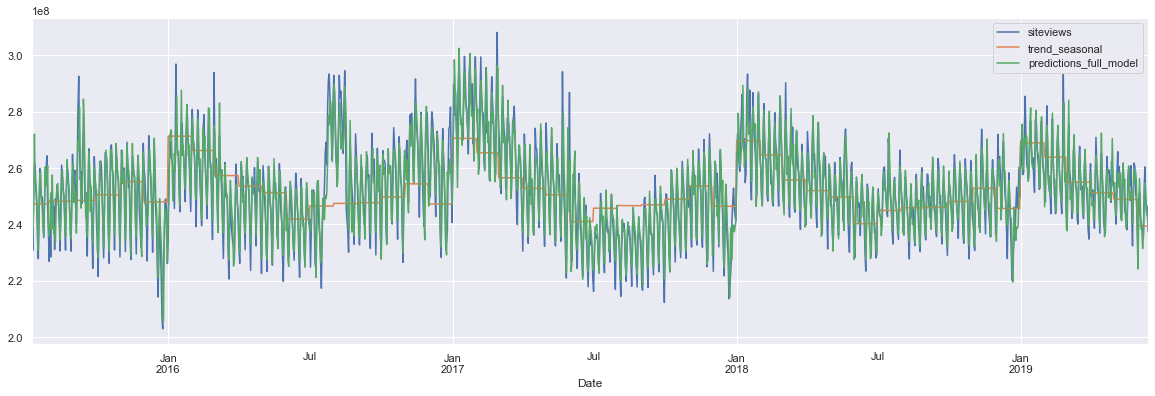

In [38]:
wiki_train[['siteviews', 'trend_seasonal', 'predictions_full_model']].plot();

#### converting float(col) in int

In [39]:
wiki_train.dtypes

siteviews                   int64
timestep                    int64
month_2                     uint8
month_3                     uint8
month_4                     uint8
month_5                     uint8
month_6                     uint8
month_7                     uint8
month_8                     uint8
month_9                     uint8
month_10                    uint8
month_11                    uint8
month_12                    uint8
trend_seasonal            float64
remainder                 float64
lag1                      float64
lag2                      float64
lag3                      float64
lag4                      float64
lag5                      float64
lag6                      float64
lag7                      float64
lag8                      float64
lag9                      float64
predictions_full_model    float64
dtype: object

In [40]:
# trying with one col
wiki_train['trend_seasonal'] = wiki_train['trend_seasonal'].astype(int)

In [41]:
for col in wiki_train.iloc[:, 13:]:
    wiki_train[col] = wiki_train[col].astype(int)

In [42]:
wiki_train.dtypes

siteviews                 int64
timestep                  int64
month_2                   uint8
month_3                   uint8
month_4                   uint8
month_5                   uint8
month_6                   uint8
month_7                   uint8
month_8                   uint8
month_9                   uint8
month_10                  uint8
month_11                  uint8
month_12                  uint8
trend_seasonal            int32
remainder                 int32
lag1                      int32
lag2                      int32
lag3                      int32
lag4                      int32
lag5                      int32
lag6                      int32
lag7                      int32
lag8                      int32
lag9                      int32
predictions_full_model    int32
dtype: object

In [43]:
wiki_train.head(3)

,siteviews,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,predictions_full_model
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-10,243476493,9,0,0,0,0,0,1,0,0,...,241986,4375008,10871805,21784826,-6374783,-20706024,-20371674,-5426646,-3798237,235609565
2015-07-11,230702775,10,0,0,0,0,0,1,0,0,...,-3799818,241986,4375008,10871805,21784826,-6374783,-20706024,-20371674,-5426646,237266147
2015-07-12,252692016,11,0,0,0,0,0,1,0,0,...,-16571372,-3799818,241986,4375008,10871805,21784826,-6374783,-20706024,-20371674,245069766


In [44]:
for col in X_full.iloc[:, 11:]:
    X_full[col] = X_full[col].astype(int)

In [45]:
X_full.dtypes

timestep    int64
month_2     uint8
month_3     uint8
month_4     uint8
month_5     uint8
month_6     uint8
month_7     uint8
month_8     uint8
month_9     uint8
month_10    uint8
month_11    uint8
month_12    int32
lag1        int32
lag2        int32
lag3        int32
lag4        int32
lag5        int32
lag6        int32
lag7        int32
lag8        int32
lag9        int32
dtype: object

In [46]:
X_full.head(3)

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,...,month_12,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-10,9,0,0,0,0,0,1,0,0,0,...,0,241986,4375008,10871805,21784826,-6374783,-20706024,-20371674,-5426646,-3798237
2015-07-11,10,0,0,0,0,0,1,0,0,0,...,0,-3799818,241986,4375008,10871805,21784826,-6374783,-20706024,-20371674,-5426646
2015-07-12,11,0,0,0,0,0,1,0,0,0,...,0,-16571372,-3799818,241986,4375008,10871805,21784826,-6374783,-20706024,-20371674


In [47]:
X_full.columns

Index(['timestep', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9'],
      dtype='object')

#### Evaluate the model

In [48]:
# Create a TimeSeriesSplit object
ts_split = TimeSeriesSplit(n_splits=5)

In [49]:
# Create the time series split
time_series_split = ts_split.split(X_full, y_full)

In [50]:
# Do the cross validation
result = cross_val_score(estimator=m_full, X=X_full, y=y_full, cv=time_series_split)
# scores are R-sqaured (default for Linear Regression in scikitlearn)

In [51]:
result.mean()

0.6221982681183469

#### Test the model
- wiki_test

In [52]:
wiki_test.head()

,siteviews
Date,
2019-06-15,235371539
2019-06-16,254821305
2019-06-17,258182343
2019-06-18,252124785
2019-06-19,243434021


In [53]:
wiki_test.isna().any()

siteviews    False
dtype: bool

In [54]:
# Last timestep of the training data
last_temp_timestep = wiki_train['timestep'][-1]

In [55]:
last_temp_timestep

1444

In [56]:
# Create a timestep for the model
wiki_test['timestep'] = list(range(last_temp_timestep +1, last_temp_timestep + 1 + len(wiki_test)))

<ipython-input-56-edcd2603d2d6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wiki_test['timestep'] = list(range(last_temp_timestep +1, last_temp_timestep + 1 + len(wiki_test)))


In [57]:
wiki_test.head()

,siteviews,timestep
Date,,
2019-06-15,235371539,1445
2019-06-16,254821305,1446
2019-06-17,258182343,1447
2019-06-18,252124785,1448
2019-06-19,243434021,1449


In [58]:
# Create the seasonal dummies for seasonality
seasonal_dummies = pd.get_dummies(wiki_test.index.month,
                                  prefix='month',
                                  drop_first=True).set_index(wiki_test.index)

wiki_test = wiki_test.join(seasonal_dummies)

In [59]:
wiki_test.head()

,siteviews,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
Date,,,,,,,,,,,,,
2019-06-15,235371539,1445,0,0,0,0,1,0,0,0,0,0,0
2019-06-16,254821305,1446,0,0,0,0,1,0,0,0,0,0,0
2019-06-17,258182343,1447,0,0,0,0,1,0,0,0,0,0,0
2019-06-18,252124785,1448,0,0,0,0,1,0,0,0,0,0,0
2019-06-19,243434021,1449,0,0,0,0,1,0,0,0,0,0,0


In [60]:
# Assign X_test
X_test = wiki_test.drop(columns=['siteviews'])
y_test = wiki_test['siteviews']

In [61]:
# Predict trend and seasonality
wiki_test['trend_seasonal'] = m_ts.predict(X_test)

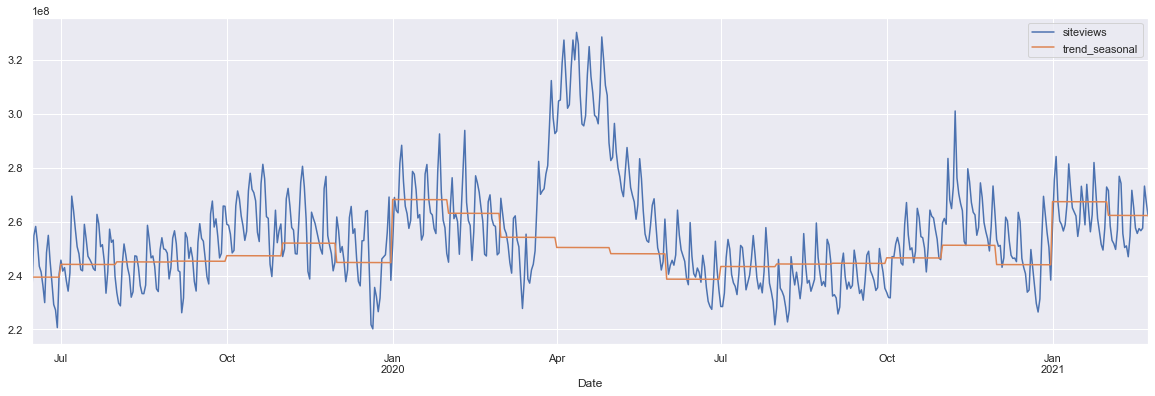

In [62]:
#plotting real_TG and the seasonal_trend
wiki_test[['siteviews', 'trend_seasonal']].plot();

In [63]:
# Calculate the remainder for the test set
wiki_test['remainder'] = wiki_test['siteviews'] - wiki_test['trend_seasonal']

In [64]:
wiki_test['lag1'] = wiki_test['remainder'].shift(1)
wiki_test['lag2'] = wiki_test['remainder'].shift(2)
wiki_test['lag3'] = wiki_test['remainder'].shift(3)
wiki_test['lag4'] = wiki_test['remainder'].shift(4)
wiki_test['lag5'] = wiki_test['remainder'].shift(5)
wiki_test['lag6'] = wiki_test['remainder'].shift(6)
wiki_test['lag7'] = wiki_test['remainder'].shift(7)
wiki_test['lag8'] = wiki_test['remainder'].shift(8)
wiki_test['lag9'] = wiki_test['remainder'].shift(9)
wiki_test.head()

,siteviews,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,remainder,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9
Date,,,,,,,,,,,,,,,,,,,,,
2019-06-15,235371539,1445,0,0,0,0,1,0,0,0,...,-4.041266e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-16,254821305,1446,0,0,0,0,1,0,0,0,...,1.541066e+07,-4.041266e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-17,258182343,1447,0,0,0,0,1,0,0,0,...,1.877387e+07,1.541066e+07,-4.041266e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-18,252124785,1448,0,0,0,0,1,0,0,0,...,1.271847e+07,1.877387e+07,1.541066e+07,-4.041266e+06,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-19,243434021,1449,0,0,0,0,1,0,0,0,...,4.029873e+06,1.271847e+07,1.877387e+07,1.541066e+07,-4.041266e+06,NaN,NaN,NaN,NaN,NaN


In [65]:
# Assign X_full_test
X_full_test = wiki_test.drop(columns=['siteviews', 'trend_seasonal', 'remainder'])

In [66]:
# fill the NaNs

X_full_test.loc['2019-06-15', 'lag1'] = wiki_train.loc['2019-06-14', 'remainder']
X_full_test.loc['2019-06-16', 'lag2'] = wiki_train.loc['2019-06-14', 'remainder']
X_full_test.loc['2019-06-17', 'lag3'] = wiki_train.loc['2019-06-14', 'remainder']
X_full_test.loc['2019-06-18', 'lag4'] = wiki_train.loc['2019-06-14', 'remainder']
X_full_test.loc['2019-06-19', 'lag5'] = wiki_train.loc['2019-06-14', 'remainder']
X_full_test.loc['2019-06-20', 'lag6'] = wiki_train.loc['2019-06-14', 'remainder']
X_full_test.loc['2019-06-21', 'lag7'] = wiki_train.loc['2019-06-14', 'remainder']
X_full_test.loc['2019-06-22', 'lag8'] = wiki_train.loc['2019-06-14', 'remainder']
X_full_test.loc['2019-06-23', 'lag9'] = wiki_train.loc['2019-06-14', 'remainder']

X_full_test.loc['2019-06-15', 'lag2'] = wiki_train.loc['2019-06-14', 'lag1']
X_full_test.loc['2019-06-16', 'lag3'] = wiki_train.loc['2019-06-14', 'lag1']
X_full_test.loc['2019-06-17', 'lag4'] = wiki_train.loc['2019-06-14', 'lag1']
X_full_test.loc['2019-06-18', 'lag5'] = wiki_train.loc['2019-06-14', 'lag1']
X_full_test.loc['2019-06-19', 'lag6'] = wiki_train.loc['2019-06-14', 'lag1']
X_full_test.loc['2019-06-20', 'lag7'] = wiki_train.loc['2019-06-14', 'lag1']
X_full_test.loc['2019-06-21', 'lag8'] = wiki_train.loc['2019-06-14', 'lag1']
X_full_test.loc['2019-06-22', 'lag9'] = wiki_train.loc['2019-06-14', 'lag1']

X_full_test.loc['2019-06-15', 'lag3'] = wiki_train.loc['2019-06-14', 'lag2']
X_full_test.loc['2019-06-16', 'lag4'] = wiki_train.loc['2019-06-14', 'lag2']
X_full_test.loc['2019-06-17', 'lag5'] = wiki_train.loc['2019-06-14', 'lag2']
X_full_test.loc['2019-06-18', 'lag6'] = wiki_train.loc['2019-06-14', 'lag2']
X_full_test.loc['2019-06-19', 'lag7'] = wiki_train.loc['2019-06-14', 'lag2']
X_full_test.loc['2019-06-20', 'lag8'] = wiki_train.loc['2019-06-14', 'lag2']
X_full_test.loc['2019-06-21', 'lag9'] = wiki_train.loc['2019-06-14', 'lag2']

X_full_test.loc['2019-06-15', 'lag4'] = wiki_train.loc['2019-06-14', 'lag3']
X_full_test.loc['2019-06-16', 'lag5'] = wiki_train.loc['2019-06-14', 'lag3']
X_full_test.loc['2019-06-17', 'lag6'] = wiki_train.loc['2019-06-14', 'lag3']
X_full_test.loc['2019-06-18', 'lag7'] = wiki_train.loc['2019-06-14', 'lag3']
X_full_test.loc['2019-06-19', 'lag8'] = wiki_train.loc['2019-06-14', 'lag3']
X_full_test.loc['2019-06-20', 'lag9'] = wiki_train.loc['2019-06-14', 'lag3']

X_full_test.loc['2019-06-15', 'lag5'] = wiki_train.loc['2019-06-14', 'lag4']
X_full_test.loc['2019-06-16', 'lag6'] = wiki_train.loc['2019-06-14', 'lag4']
X_full_test.loc['2019-06-17', 'lag7'] = wiki_train.loc['2019-06-14', 'lag4']
X_full_test.loc['2019-06-18', 'lag8'] = wiki_train.loc['2019-06-14', 'lag4']
X_full_test.loc['2019-06-19', 'lag9'] = wiki_train.loc['2019-06-14', 'lag4']

X_full_test.loc['2019-06-15', 'lag6'] = wiki_train.loc['2019-06-14', 'lag5']
X_full_test.loc['2019-06-16', 'lag7'] = wiki_train.loc['2019-06-14', 'lag5']
X_full_test.loc['2019-06-17', 'lag8'] = wiki_train.loc['2019-06-14', 'lag5']
X_full_test.loc['2019-06-18', 'lag9'] = wiki_train.loc['2019-06-14', 'lag5']

X_full_test.loc['2019-06-15', 'lag7'] = wiki_train.loc['2019-06-14', 'lag6']
X_full_test.loc['2019-06-16', 'lag8'] = wiki_train.loc['2019-06-14', 'lag6']
X_full_test.loc['2019-06-17', 'lag9'] = wiki_train.loc['2019-06-14', 'lag6']

X_full_test.loc['2019-06-15', 'lag8'] = wiki_train.loc['2019-06-14', 'lag7']
X_full_test.loc['2019-06-16', 'lag9'] = wiki_train.loc['2019-06-14', 'lag7']

X_full_test.loc['2019-06-15', 'lag9'] = wiki_train.loc['2019-06-14', 'lag8']

In [67]:
#wiki_train.iloc[1435:, 10:]

In [68]:
wiki_train.head(4)

,siteviews,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,predictions_full_model
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-10,243476493,9,0,0,0,0,0,1,0,0,...,241986,4375008,10871805,21784826,-6374783,-20706024,-20371674,-5426646,-3798237,235609565
2015-07-11,230702775,10,0,0,0,0,0,1,0,0,...,-3799818,241986,4375008,10871805,21784826,-6374783,-20706024,-20371674,-5426646,237266147
2015-07-12,252692016,11,0,0,0,0,0,1,0,0,...,-16571372,-3799818,241986,4375008,10871805,21784826,-6374783,-20706024,-20371674,245069766
2015-07-13,261379918,12,0,0,0,0,0,1,0,0,...,5420032,-16571372,-3799818,241986,4375008,10871805,21784826,-6374783,-20706024,272038244


In [69]:
# Create the predictions
wiki_test['predictions_full_model'] = m_full.predict(X_full_test)

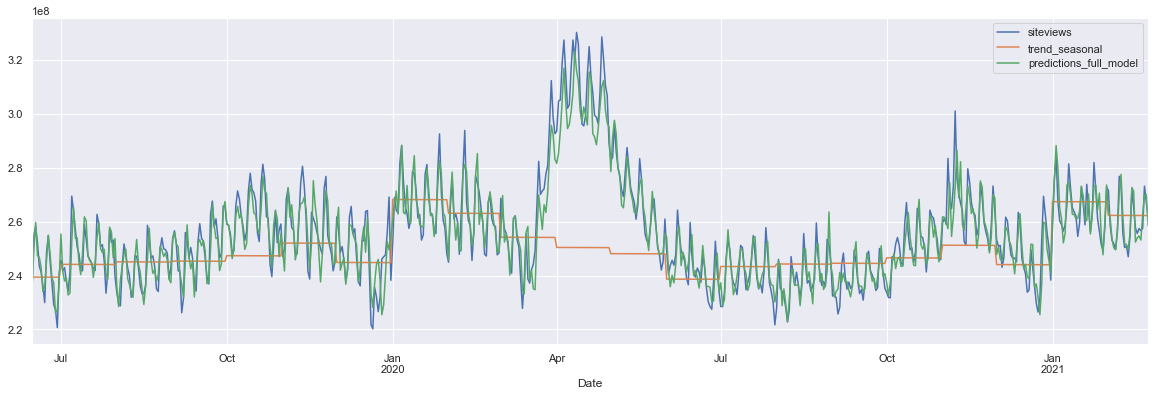

In [70]:
#plotting real_TG vs pred
wiki_test[['siteviews', 'trend_seasonal', 'predictions_full_model']].plot();

In [71]:
wiki_test.head(3)

,siteviews,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,predictions_full_model
Date,,,,,,,,,,,,,,,,,,,,,
2019-06-15,235371539,1445,0,0,0,0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.356923e+08
2019-06-16,254821305,1446,0,0,0,0,1,0,0,0,...,-4.041266e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.496224e+08
2019-06-17,258182343,1447,0,0,0,0,1,0,0,0,...,1.541066e+07,-4.041266e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.596831e+08


In [72]:
X_full_test.head(3)

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,...,month_12,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9
Date,,,,,,,,,,,,,,,,,,,,,
2019-06-15,1445,0,0,0,0,1,0,0,0,0,...,0,-2.020959e+06,7.002198e+06,5251557.0,9687579.0,20942676.0,13604149.0,-4172914.0,-2147877.0,181423.0
2019-06-16,1446,0,0,0,0,1,0,0,0,0,...,0,-4.041266e+06,-2.020959e+06,7002198.0,5251557.0,9687579.0,20942676.0,13604149.0,-4172914.0,-2147877.0
2019-06-17,1447,0,0,0,0,1,0,0,0,0,...,0,1.541066e+07,-4.041266e+06,-2020959.0,7002198.0,5251557.0,9687579.0,20942676.0,13604149.0,-4172914.0


In [73]:
m_full.score(X_full_test, wiki_test['siteviews'])  

0.8894047956505234

### complete data-set (train+test.plot())

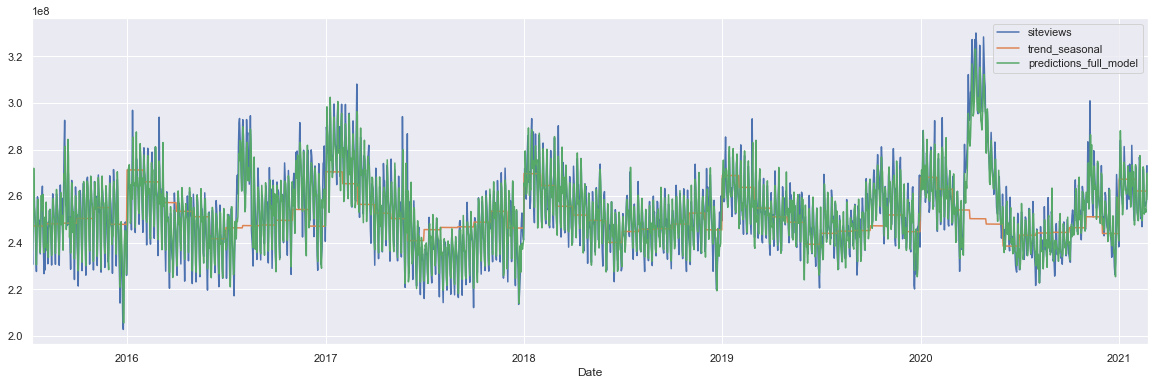

In [74]:
# Create the complete dataset and plot it
wiki_full = wiki_train[['siteviews', 'trend_seasonal', 'predictions_full_model']].append(wiki_test[['siteviews', 'trend_seasonal', 'predictions_full_model']])
wiki_full.plot();

In [75]:
#showing predictions as DataFrame
y_pred = wiki_test['predictions_full_model']
y_pred2 = []
for val in y_pred:
    val = int(float(val))
    y_pred2.append(val)
    
comp = pd.DataFrame({'Actual': wiki_test['siteviews'], 'Predicted': y_pred2})
comp

,Actual,Predicted
Date,,
2019-06-15,235371539,235692336
2019-06-16,254821305,249622438
2019-06-17,258182343,259683104
2019-06-18,252124785,247290756
2019-06-19,243434021,246820674
...,...,...
2021-02-19,256601130,253169019
2021-02-20,257535699,262329689
2021-02-21,273132746,269766372


In [76]:
comp.dtypes

Actual       int64
Predicted    int64
dtype: object

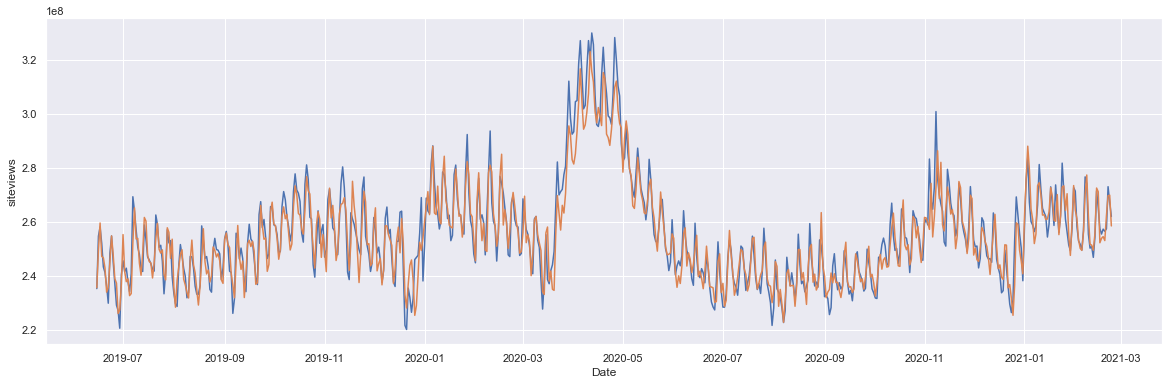

In [77]:
#plotting predictions for data_test
sns.lineplot(x=wiki_test.index, y=wiki_test['siteviews'])
sns.lineplot(x=wiki_test.index, y=y_pred);

In [78]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(wiki_test['siteviews'], y_pred2))
print('Mean Squared Error:', metrics.mean_squared_error(wiki_test['siteviews'], y_pred2))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(wiki_test['siteviews'], y_pred2)))

Mean Absolute Error: 4686596.761290323
Mean Squared Error: 40059182368795.04
Root Mean Squared Error: 6329232.368051835


In [79]:
# Combine train and test data -> whole dataset with all features we created. 
data_combined = wiki_train.append(wiki_test)
data_combined.tail()

,siteviews,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,predictions_full_model
Date,,,,,,,,,,,,,,,,,,,,,
2021-02-19,256601130,2060,1,0,0,0,0,0,0,0,...,-4.837622e+06,-6.658917e+06,-4.639698e+06,3.098094e+06,9.329346e+06,-7.681041e+06,-1.530217e+07,-1.126427e+07,-1.188633e+07,2.531690e+08
2021-02-20,257535699,2061,1,0,0,0,0,0,0,0,...,-5.635370e+06,-4.837622e+06,-6.658917e+06,-4.639698e+06,3.098094e+06,9.329346e+06,-7.681041e+06,-1.530217e+07,-1.126427e+07,2.623297e+08
2021-02-21,273132746,2062,1,0,0,0,0,0,0,0,...,-4.698637e+06,-5.635370e+06,-4.837622e+06,-6.658917e+06,-4.639698e+06,3.098094e+06,9.329346e+06,-7.681041e+06,-1.530217e+07,2.697664e+08
2021-02-22,267265241,2063,1,0,0,0,0,0,0,0,...,1.090057e+07,-4.698637e+06,-5.635370e+06,-4.837622e+06,-6.658917e+06,-4.639698e+06,3.098094e+06,9.329346e+06,-7.681041e+06,2.699967e+08
2021-02-23,262096672,2064,1,0,0,0,0,0,0,0,...,5.035233e+06,1.090057e+07,-4.698637e+06,-5.635370e+06,-4.837622e+06,-6.658917e+06,-4.639698e+06,3.098094e+06,9.329346e+06,2.585928e+08


### Predict the future

In [80]:
# Assign X and y 
X_combined = data_combined.drop(columns=['siteviews', 'trend_seasonal', 'remainder', 'predictions_full_model'])
y_combined = data_combined['siteviews']

In [81]:
# fill the NaNs

X_combined.loc['2019-06-15', 'lag1'] = wiki_train.loc['2019-06-14', 'remainder']
X_combined.loc['2019-06-16', 'lag2'] = wiki_train.loc['2019-06-14', 'remainder']
X_combined.loc['2019-06-17', 'lag3'] = wiki_train.loc['2019-06-14', 'remainder']
X_combined.loc['2019-06-18', 'lag4'] = wiki_train.loc['2019-06-14', 'remainder']
X_combined.loc['2019-06-19', 'lag5'] = wiki_train.loc['2019-06-14', 'remainder']
X_combined.loc['2019-06-20', 'lag6'] = wiki_train.loc['2019-06-14', 'remainder']
X_combined.loc['2019-06-21', 'lag7'] = wiki_train.loc['2019-06-14', 'remainder']
X_combined.loc['2019-06-22', 'lag8'] = wiki_train.loc['2019-06-14', 'remainder']
X_combined.loc['2019-06-23', 'lag9'] = wiki_train.loc['2019-06-14', 'remainder']

X_combined.loc['2019-06-15', 'lag2'] = wiki_train.loc['2019-06-14', 'lag1']
X_combined.loc['2019-06-16', 'lag3'] = wiki_train.loc['2019-06-14', 'lag1']
X_combined.loc['2019-06-17', 'lag4'] = wiki_train.loc['2019-06-14', 'lag1']
X_combined.loc['2019-06-18', 'lag5'] = wiki_train.loc['2019-06-14', 'lag1']
X_combined.loc['2019-06-19', 'lag6'] = wiki_train.loc['2019-06-14', 'lag1']
X_combined.loc['2019-06-20', 'lag7'] = wiki_train.loc['2019-06-14', 'lag1']
X_combined.loc['2019-06-21', 'lag8'] = wiki_train.loc['2019-06-14', 'lag1']
X_combined.loc['2019-06-22', 'lag9'] = wiki_train.loc['2019-06-14', 'lag1']

X_combined.loc['2019-06-15', 'lag3'] = wiki_train.loc['2019-06-14', 'lag2']
X_combined.loc['2019-06-16', 'lag4'] = wiki_train.loc['2019-06-14', 'lag2']
X_combined.loc['2019-06-17', 'lag5'] = wiki_train.loc['2019-06-14', 'lag2']
X_combined.loc['2019-06-18', 'lag6'] = wiki_train.loc['2019-06-14', 'lag2']
X_combined.loc['2019-06-19', 'lag7'] = wiki_train.loc['2019-06-14', 'lag2']
X_combined.loc['2019-06-20', 'lag8'] = wiki_train.loc['2019-06-14', 'lag2']
X_combined.loc['2019-06-21', 'lag9'] = wiki_train.loc['2019-06-14', 'lag2']

X_combined.loc['2019-06-15', 'lag4'] = wiki_train.loc['2019-06-14', 'lag3']
X_combined.loc['2019-06-16', 'lag5'] = wiki_train.loc['2019-06-14', 'lag3']
X_combined.loc['2019-06-17', 'lag6'] = wiki_train.loc['2019-06-14', 'lag3']
X_combined.loc['2019-06-18', 'lag7'] = wiki_train.loc['2019-06-14', 'lag3']
X_combined.loc['2019-06-19', 'lag8'] = wiki_train.loc['2019-06-14', 'lag3']
X_combined.loc['2019-06-20', 'lag9'] = wiki_train.loc['2019-06-14', 'lag3']

X_combined.loc['2019-06-15', 'lag5'] = wiki_train.loc['2019-06-14', 'lag4']
X_combined.loc['2019-06-16', 'lag6'] = wiki_train.loc['2019-06-14', 'lag4']
X_combined.loc['2019-06-17', 'lag7'] = wiki_train.loc['2019-06-14', 'lag4']
X_combined.loc['2019-06-18', 'lag8'] = wiki_train.loc['2019-06-14', 'lag4']
X_combined.loc['2019-06-19', 'lag9'] = wiki_train.loc['2019-06-14', 'lag4']

X_combined.loc['2019-06-15', 'lag6'] = wiki_train.loc['2019-06-14', 'lag5']
X_combined.loc['2019-06-16', 'lag7'] = wiki_train.loc['2019-06-14', 'lag5']
X_combined.loc['2019-06-17', 'lag8'] = wiki_train.loc['2019-06-14', 'lag5']
X_combined.loc['2019-06-18', 'lag9'] = wiki_train.loc['2019-06-14', 'lag5']

X_combined.loc['2019-06-15', 'lag7'] = wiki_train.loc['2019-06-14', 'lag6']
X_combined.loc['2019-06-16', 'lag8'] = wiki_train.loc['2019-06-14', 'lag6']
X_combined.loc['2019-06-17', 'lag9'] = wiki_train.loc['2019-06-14', 'lag6']

X_combined.loc['2019-06-15', 'lag8'] = wiki_train.loc['2019-06-14', 'lag7']
X_combined.loc['2019-06-16', 'lag9'] = wiki_train.loc['2019-06-14', 'lag7']

X_combined.loc['2019-06-15', 'lag9'] = wiki_train.loc['2019-06-14', 'lag8']

In [82]:
# Re-train the model on the whole dataset
m_combined = LinearRegression()
m_combined.fit(X_combined, y_combined)

LinearRegression()

In [83]:
# What is the first date in the future? --> 2021-02-24
timestep = data_combined['timestep'].max() + 1
months = [1] + [0]*10
lag1 = data_combined.loc['2020-02-23', 'remainder']
lag2 = data_combined.loc['2020-02-23', 'lag1']
lag3 = data_combined.loc['2020-02-23', 'lag2']
lag4 = data_combined.loc['2020-02-23', 'lag3']
lag5 = data_combined.loc['2020-02-23', 'lag4']
lag6 = data_combined.loc['2020-02-23', 'lag5']
lag7 = data_combined.loc['2020-02-23', 'lag6']
lag8 = data_combined.loc['2020-02-23', 'lag7']
lag9 = data_combined.loc['2020-02-23', 'lag8']


In [84]:
# create a new sample
X_fut = []
X_fut.append(timestep)
X_fut.extend(months)
X_fut.append(lag1)
X_fut.append(lag2)
X_fut.append(lag3)
X_fut.append(lag4)
X_fut.append(lag5)
X_fut.append(lag6)
X_fut.append(lag7)
X_fut.append(lag8)
X_fut.append(lag9)

In [85]:
X_fut = pd.DataFrame([X_fut], columns = ['timestep', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12','lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6',
                                        'lag7', 'lag8', 'lag9'])
X_fut.rename(index={0:pd.to_datetime("2021-02-24 00:00:00")},inplace=True)
X_fut

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,...,month_12,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9
2021-02-24,2065,1,0,0,0,0,0,0,0,0,...,0,4.312231e+06,-1.579439e+07,-1.514822e+07,-2.984929e+06,2.113828e+06,7.829771e+06,1.128751e+07,1.391540e+07,-6.857618e+06


In [86]:
# Prediction for 2021-02-24
m_combined.predict(X_fut)

array([2.70262021e+08])

In [87]:
X_fut['predictions_full_model'] = m_combined.predict(X_fut)

In [88]:
# create one df for plotting both

cols = ['timestep', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9',
        'siteviews', 'trend_seasonal', 'predictions_full_model']
temp_f = wiki_test[cols].append(X_fut)

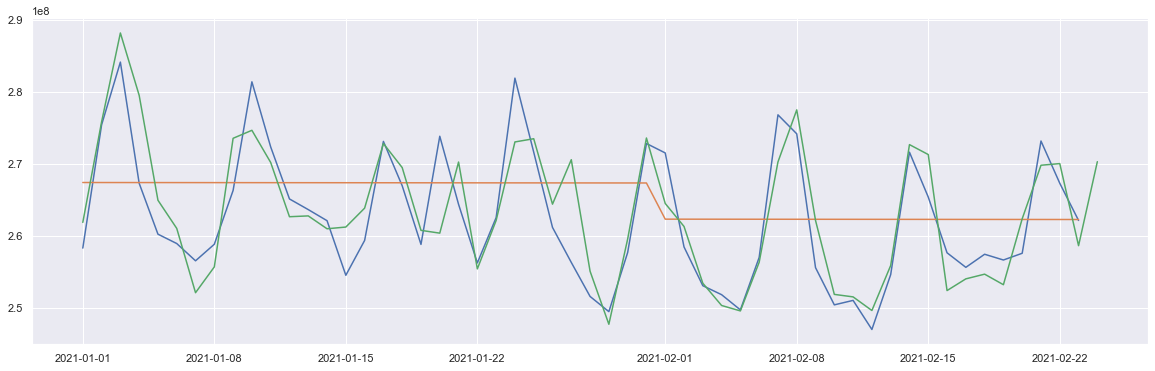

In [89]:
plt.plot(temp_f['2021-01-01':][['siteviews', 'trend_seasonal', 'predictions_full_model']]);

In [90]:
X_fut['predictions_full_model'][0]

270262021.1109048

In [91]:
int(float(X_fut['predictions_full_model'][0]))

270262021

#### Dif model

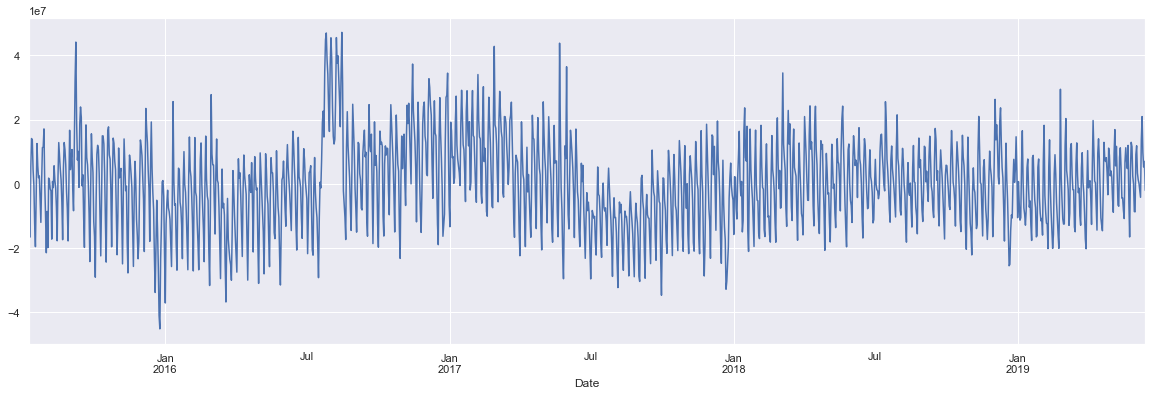

In [92]:
wiki_train['remainder'].plot();

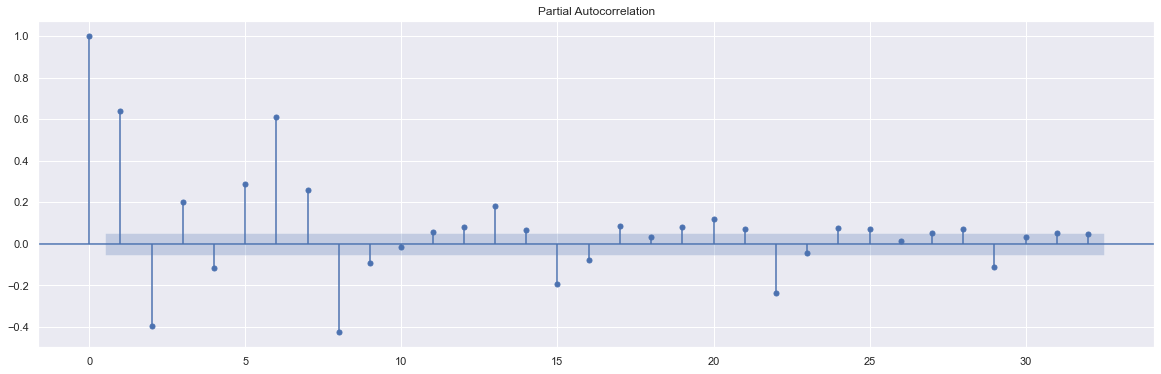

In [93]:
# Plot the PACF
plot_pacf(wiki_train['remainder']);

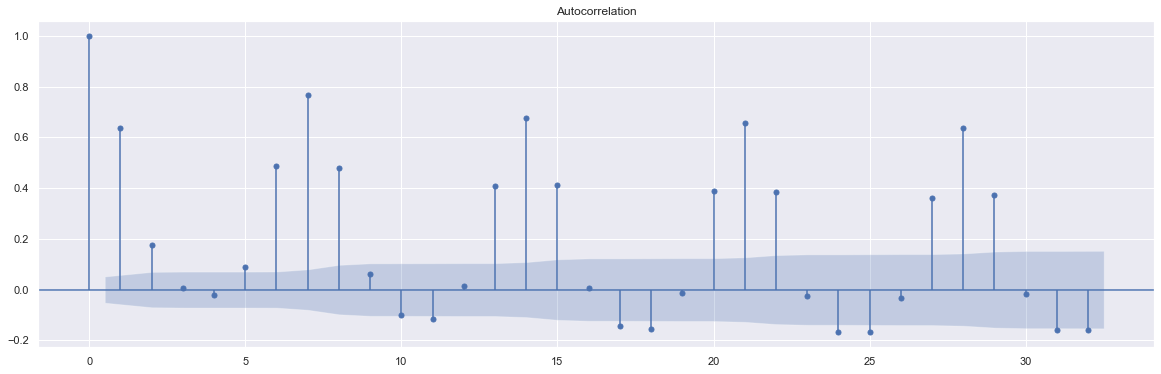

In [94]:
# Plot the ACF
plot_acf(wiki_train['remainder']);

### AR-Model

In [95]:
wiki_train.index

DatetimeIndex(['2015-07-10', '2015-07-11', '2015-07-12', '2015-07-13',
               '2015-07-14', '2015-07-15', '2015-07-16', '2015-07-17',
               '2015-07-18', '2015-07-19',
               ...
               '2019-06-05', '2019-06-06', '2019-06-07', '2019-06-08',
               '2019-06-09', '2019-06-10', '2019-06-11', '2019-06-12',
               '2019-06-13', '2019-06-14'],
              dtype='datetime64[ns]', name='Date', length=1436, freq=None)

In [96]:
#set freq of data
wiki_train.index.freq = 'd'

In [97]:
# Fit a statsmodels model
ar_model = AutoReg(wiki_train['remainder'], lags=9, old_names=False).fit()

In [98]:
# Look at the summary
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                 1436
Model:                     AutoReg(9)   Log Likelihood              -24346.274
Method:               Conditional MLE   S.D. of innovations        6213412.780
Date:                Fri, 26 Feb 2021   AIC                             31.300
Time:                        14:24:56   BIC                             31.340
Sample:                    07-19-2015   HQIC                            31.315
                         - 06-14-2019                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.236e+04   1.64e+05      0.075      0.940    -3.1e+05    3.35e+05
remainder.L1     0.7675      0.026     29.108      0.000       0.716       0.819
remainder.L2    -0.1874      0.032     -5.863      0.000      -0.250      -0.125
remainder.L3     0.1179      0.029      4.052      0.000       0.061       0.175
remainder.L4    -0.0260      0.029     -0.908      0.364      -0.082       0.030
remainder.L5    -0.1320      0.028     -4.643      0.000      -0.188      -0.076
remainder.L6     0.2255      0.029      7.875      0.000       0.169       0.282
remainder.L7     0.5322      0.029     18.309      0.000       0.475       0.589
remainder.L8    -0.3520      0.032    -11.035      0.000      -0.415      -0.289
remainder.L9    -0.0891      0.026     -3.382      0.001      -0.141      -0.037
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6373           -0.7951j            1.0189           -0.1425
AR.2            0.6373           +0.7951j            1.0189            0.1425
AR.3            1.1034           -0.0000j            1.1034           -0.0000
AR.4            1.2947           -0.0000j            1.2947           -0.0000
AR.5           -0.2273           -1.0058j            1.0312           -0.2854
AR.6           -0.2273           +1.0058j            1.0312            0.2854
AR.7           -1.0703           -0.5194j            1.1897           -0.4281
AR.8           -1.0703           +0.5194j            1.1897            0.4281
AR.9           -5.0300           -0.0000j            5.0300           -0.5000
-----------------------------------------------------------------------------
"""

In [99]:
ar_model.predict() #.dropna().astype('int64')

Date
2015-07-10             NaN
2015-07-11             NaN
2015-07-12             NaN
2015-07-13             NaN
2015-07-14             NaN
                  ...     
2019-06-10    1.543041e+07
2019-06-11    1.016411e+07
2019-06-12    4.033503e+06
2019-06-13    3.744080e+06
2019-06-14    9.381874e+05
Freq: D, Length: 1436, dtype: float64

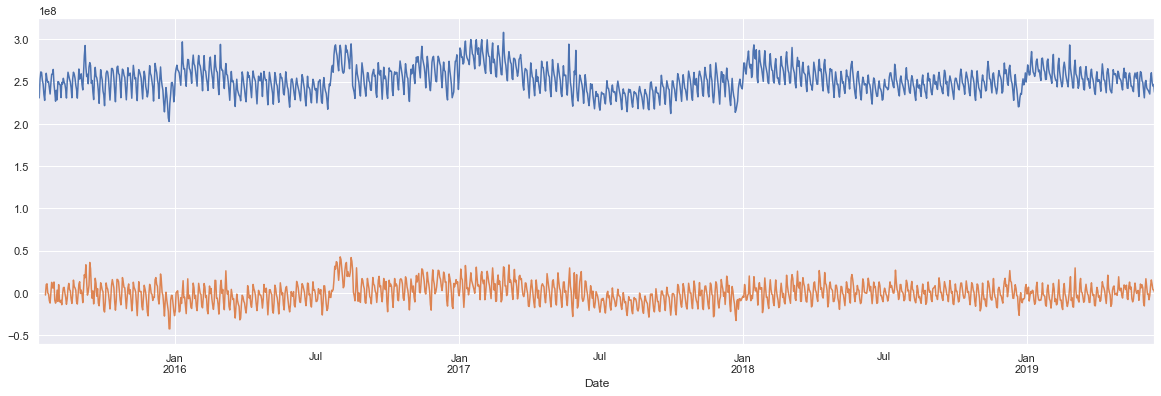

In [133]:
# Plot the prediction
wiki_train['siteviews'].plot()
plt.plot(ar_model.predict());

#### ARIMA

In [101]:
# Fit an ARIMA model
arima_model = ARIMA(wiki_train['siteviews'], order=(1,0,1)).fit() # order is (p,d,q) or (ar,i,ma)

In [102]:
# Look at the summary
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              siteviews   No. Observations:                 1436
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -25151.461
Date:                Fri, 26 Feb 2021   AIC                          50310.923
Time:                        14:24:57   BIC                          50332.001
Sample:                    07-10-2015   HQIC                         50318.792
                         - 06-14-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.522e+08    2.3e-10    1.1e+18      0.000    2.52e+08    2.52e+08
ar.L1          0.4977      0.026     19.410      0.000       0.447       0.548
ma.L1          0.6002      0.026     23.329      0.000       0.550       0.651
sigma2      9.658e+13   2.15e-17    4.5e+30      0.000    9.66e+13    9.66e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                73.58
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                             0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.18e+46. Standard errors may be unstable.
"""

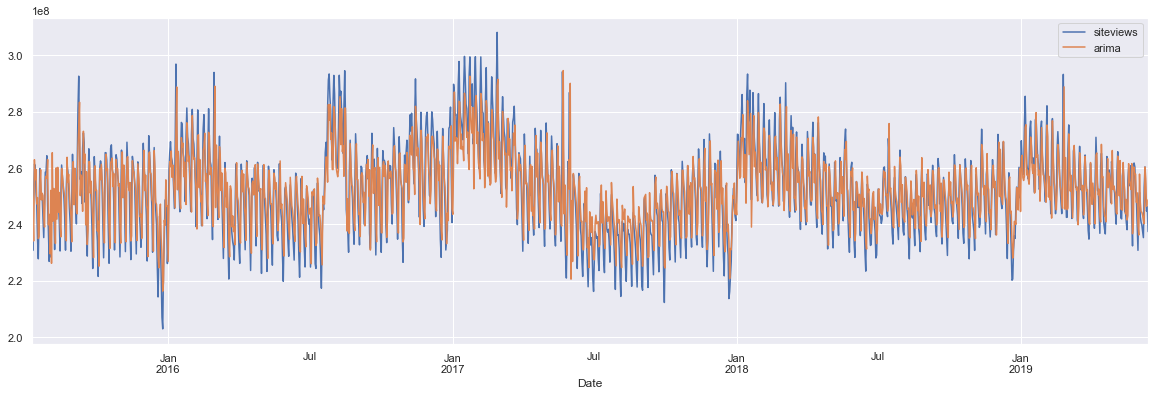

In [103]:
# Plot all time series
wiki_train['siteviews'].plot()
#plt.plot(ar_model.predict(), label='ar')
plt.plot(arima_model.predict(), label='arima')
plt.legend()
plt.plot();

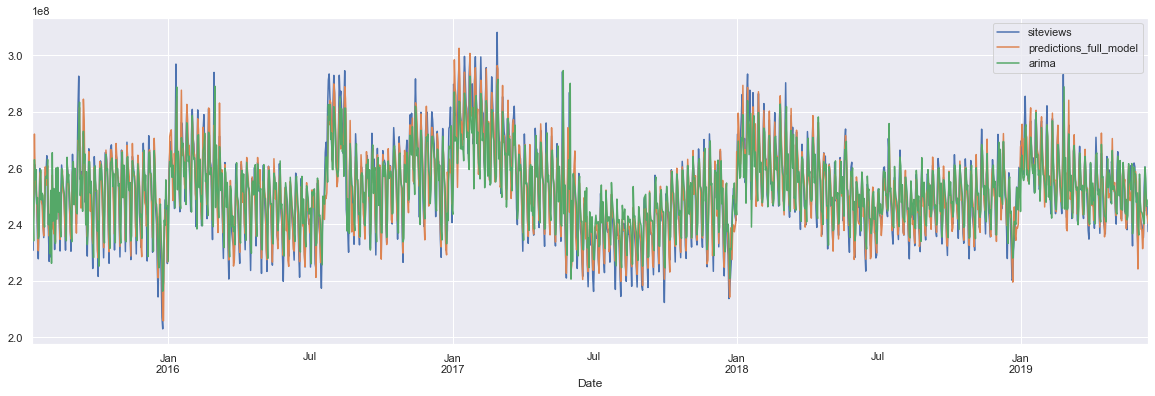

In [128]:
# Plot all time series
wiki_train['siteviews'].plot()
wiki_train['predictions_full_model'].plot()
#plt.plot(ar_model.predict(), label='ar')
plt.plot(arima_model.predict(), label='arima')
plt.legend()
plt.plot();

In [104]:
predictions = arima_model.predict(start=len(wiki_train), end=len(wiki_train)+len(wiki_test)-1, dynamic=False)

In [105]:
predictions.astype('int64')

2019-06-15    238031976
2019-06-16    245137260
2019-06-17    248673503
2019-06-18    250433463
2019-06-19    251309380
                ...    
2021-02-19    252177249
2021-02-20    252177249
2021-02-21    252177249
2021-02-22    252177249
2021-02-23    252177249
Freq: D, Name: predicted_mean, Length: 620, dtype: int64

In [106]:
#printing the values:
for i in range(len(predictions)):
    print('predicted = %.0f, expected = %.0f, diff = %.0f' % 
          (predictions[i].astype('int64'), wiki_test['siteviews'][i].astype('int64'), 
           -(wiki_test['siteviews'][i].astype('int64') - predictions[i].astype('int64'))))

predicted = 238031976, expected = 235371539, diff = 2660437
predicted = 245137260, expected = 254821305, diff = -9684045
predicted = 248673503, expected = 258182343, diff = -9508840
predicted = 250433463, expected = 252124785, diff = -1691322
predicted = 251309380, expected = 243434021, diff = 7875359
predicted = 251745318, expected = 241309757, diff = 10435561
predicted = 251962280, expected = 236323431, diff = 15638849
predicted = 252070260, expected = 229959305, diff = 22110955
predicted = 252124002, expected = 248450231, diff = 3673771
predicted = 252150748, expected = 254881496, diff = -2730748
predicted = 252164059, expected = 245275441, diff = 6888618
predicted = 252170685, expected = 237516975, diff = 14653710
predicted = 252173982, expected = 229243833, diff = 22930149
predicted = 252175623, expected = 227239850, diff = 24935773
predicted = 252176439, expected = 220693827, diff = 31482612
predicted = 252176846, expected = 240513678, diff = 11663168
predicted = 252177048, expec

In [108]:
print(metrics.mean_absolute_error(wiki_test['siteviews'], predictions))

13979081.7916724


In [118]:
print('Mean Squared Error:', metrics.mean_squared_error(wiki_test['siteviews'], predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(wiki_test['siteviews'], predictions)))

Mean Squared Error: 374238262820015.75
Root Mean Squared Error: 19345238.76358252


In [122]:
rmse = np.sqrt(metrics.mean_squared_error(wiki_test['siteviews'], predictions))

In [123]:
rmse

19345238.76358252

_____

In [137]:
print('LR')
print('Mean Absolute Error:', metrics.mean_absolute_error(wiki_test['siteviews'], y_pred2)/1000000)
print('Mean Squared Error:', metrics.mean_squared_error(wiki_test['siteviews'], y_pred2)/1000000000000)
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(wiki_test['siteviews'], y_pred2))/1000000)

print('ARIMA')
print('Mean Absolute Error:', metrics.mean_absolute_error(wiki_test['siteviews'], predictions)/1000000)
print('Mean Squared Error:', metrics.mean_squared_error(wiki_test['siteviews'], predictions)/1000000000000)
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(wiki_test['siteviews'], predictions))/1000000)

LR
Mean Absolute Error: 4.686596761290323
Mean Squared Error: 40.05918236879504
Root Mean Squared Error: 6.329232368051835
ARIMA
Mean Absolute Error: 13.9790817916724
Mean Squared Error: 374.23826282001573
Root Mean Squared Error: 19.345238763582522
